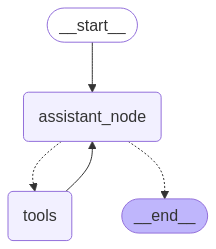

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from tools.function_calculator import calculate_formula
from tools.tz_convertor import convert_time
from tools.llm_tools import translate_text, explain_word



assistant_system_prompt = \
    """#You are a text tool that can solve several tasks, based in the user input.

    #Task list and when to use each task:
    - Word explanation - IF the user input is a word or two words (in any language). Use {native_language} for the explanation.
    - Text translation - IF the user input is more then 2 words and is in a foreign language.
        The native language is {native_language}, so any other language is foreign.
        IF THE USER INPUT IS IN {native_language}, DO NOT SOLVE THIS TASK.
    - Time zone converion - IF the user input has information about time that doesn't match the current time zone.
    - Math formula calculation - use it if the user input has math formula

    DON'T CHAT WITH THE USER, ONLY SOLVE THE TASK.

    If the user input could have several tasks – you'll need to pick the most relevant one and solve it.
    If the task was already solved – you don't need to solve it again. Proceed to the next task, if any.

    If the user input is not related to any of the tasks, or all tasks were already solved – output "final response: [your response]" (brackets shouldn't be included).

    #Below are the examples how you can solve each task:
    """

word_explanation_system_prompt = \
    """
    ##Word explanation:
    
    **Query:** "algorithm"  
    **Answer:** "Алгоритм - это последовательность действий, которая решает определенную задачу."  (assuming that the native language is Russian)

    **RETURN ONLY THE ANSWER, NO OTHER TEXT.**

    To generate the answer, you need to:
    1. Trigger explain_word tool with 2 arguments: the user's word and the native_language wich is {native_language}
    2. Pick the result from the explain_word tool call
    """

text_translation_system_prompt = \
    """
    ##Text translation:
    
    **Query:** "Hello world, how are you?"  
    **Answer:** "Привет мир, как дела?"

    **RETURN ONLY THE ANSWER, NO OTHER TEXT.**

    To generate the answer, you need to:
    1. Trigger translate_text tool with 2 arguments: the user's text and the target_language wich is {native_language}
    2. Pick the result from the translate_text tool call
    """

tz_system_prompt = \
    """
    ##Time zone converion:
    
    **Query:** "let's meet at H1H1:M1M1 [time_zone/location] time"  
    **Answer:** "let's meet at H2H2:M2M2 [current_location] time"
    
    In this conversation:
    - H1H1:M1M1 is time of some [time_zone] (e.g. CET, UTC+2) or [location] (e.g. Berlin)
    - H2H2:M2M2 is time of [current_location]
    - [current_location] is {current_location}

    Few more examples:
    **Query:** "давай встретимся в 3 дня Берлину"  
    **Answer:** "давай встретимся в 2 дня по Никосии"  (in this toy example the current location is set to Nicosia)

    **Query:** "можем ли мы перенести встречу в 10 AM по NY на час вперед?"  
    **Answer:** "можем ли мы перенести встречу в 3 PM по Барселоне на час вперед?" (in this toy example the current location is set to Barcelona)

    **RETURN ONLY THE ANSWER, NO OTHER TEXT.**

    To generate the answer, you need to:
    1. convert [time_zone/location] to the correct_time_zone in python format (e.g. "Europe/Berlin", "America/New_York")
    2. convert current_location which is {current_location} to the correct_current_time_zone in python format (e.g. "Europe/Berlin", "America/New_York")
    3. run a function convert_time with the correct arguments (H1H1:M1M1, correct_time_zone, correct_current_time_zone)
    4. construct the answer from the result of the convert_time function in the language of the question and with correct wording 
       (considering cases, declensions, etc.), deviating minimally from the original form of the sentence.
    """

math_formula_calculation_system_prompt = \
    """
    ## Math formula calculation:
    
    **Query:** "- (1/N) * SUM ( y_true * log(y_pred) ) where N=5 and y_true=[0,0,0,0,0] and y_pred=[0.1,0.2,0.3,0.4,0.5]"  
    **Answer:** "0."

    **RETURN ONLY THE ANSWER, NO OTHER TEXT.**

    To generate the answer, you need to:
    1. Write a python code that calculates the formula. 
       You are allowed to use the following safe built-ins: abs, min, max, sum, len, range, math, numpy, datetime
       For the previous example, the code should be:
       ```python
       import numpy as np
       
       N = 5
       y_true = [0, 0, 0, 0, 0]
       y_pred = [0.1, 0.2, 0.3, 0.4, 0.5]
       
       result = -(1/N) * sum(y_true[i] * np.log(y_pred[i]) for i in range(len(y_true)))
       ```
    2. trigger calculate_formula tool with the code written by you as an argument
    3. Pick the result from the calculate_formula tool call
    """
current_location = "Ларнака"
native_language = "Русский"

system_message = SystemMessage(
    content='\n'.join([assistant_system_prompt.format(native_language=native_language),
                       word_explanation_system_prompt.format(native_language=native_language),
                       text_translation_system_prompt.format(native_language=native_language),
                       tz_system_prompt.format(current_location=current_location), 
                       math_formula_calculation_system_prompt,]))

tools = [convert_time, calculate_formula, translate_text, explain_word]

llm = ChatOpenAI(model="gpt-4o").bind_tools(tools, parallel_tool_calls=False)

def assistant_node(state: MessagesState):
    return {"messages": [llm.invoke([system_message] + state["messages"])]}


builder = StateGraph(MessagesState)

builder.add_node(assistant_node)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant_node")
builder.add_conditional_edges(
    "assistant_node",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant_node")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [11]:
messages = react_graph.invoke(
    {"messages": [HumanMessage(content="Photosynthesis")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Photosynthesis
================================== Ai Message ==================================
Tool Calls:
  explain_word (call_4XjncsGjuQuKgXXvyd6IV4H3)
 Call ID: call_4XjncsGjuQuKgXXvyd6IV4H3
  Args:
    word: Photosynthesis
    native_language: Русский
================================= Tool Message =================================
Name: explain_word

Фотосинтез (английский: Photosynthesis) — это процесс, с помощью которого растения, водоросли и некоторые бактерии преобразуют световую энергию в химическую, создавая органические вещества из углекислого газа и воды. В результате фотосинтеза выделяется кислород, который необходим для дыхания живых организмов. Пример использования: "Фотосинтез является основным источником кислорода в атмосфере Земли". Этот процесс происходит в хлоропластах клеток растений и является ключевым для поддержания жизни на планете.
================================== Ai Message =

In [12]:
messages = react_graph.invoke(
    {"messages": [HumanMessage(content="давай встретимся в 3 дня по Барселоне")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

давай встретимся в 3 дня по Барселоне
================================== Ai Message ==================================
Tool Calls:
  convert_time (call_Bj3v0KDtjblhrSBB0kBvuzQu)
 Call ID: call_Bj3v0KDtjblhrSBB0kBvuzQu
  Args:
    time_in: 15:00
    tz_in: Europe/Madrid
    tz_out: Asia/Nicosia
================================= Tool Message =================================
Name: convert_time

16:00
================================== Ai Message ==================================

давай встретимся в 4 дня по Ларнаке


In [13]:
messages = react_graph.invoke(
    {"messages": [HumanMessage(content="log(1000 * 66)")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

log(1000 * 66)
================================== Ai Message ==================================
Tool Calls:
  calculate_formula (call_BjwcxcT4LeUklzXldrPpTQg9)
 Call ID: call_BjwcxcT4LeUklzXldrPpTQg9
  Args:
    user_script: import math

# Calculate the logarithm of 1000 * 66
result = math.log(1000 * 66)
================================= Tool Message =================================
Name: calculate_formula

11.097410021008562
================================== Ai Message ==================================

11.097410021008562.


In [14]:
messages = react_graph.invoke(
    {"messages": [HumanMessage(content="The issue is that LangChain’s bind_tools expects a function with a valid __name__ attribute, which classes (even callables) don’t naturally have. Since functools.partial and lambda also don’t provide __name__, the best approach is to use a decorator-based wrapper to dynamically set __name__.")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

The issue is that LangChain’s bind_tools expects a function with a valid __name__ attribute, which classes (even callables) don’t naturally have. Since functools.partial and lambda also don’t provide __name__, the best approach is to use a decorator-based wrapper to dynamically set __name__.
================================== Ai Message ==================================
Tool Calls:
  translate_text (call_SPSJv6NClJQvVrvE0hASjFRh)
 Call ID: call_SPSJv6NClJQvVrvE0hASjFRh
  Args:
    text: The issue is that LangChain’s bind_tools expects a function with a valid __name__ attribute, which classes (even callables) don’t naturally have. Since functools.partial and lambda also don’t provide __name__, the best approach is to use a decorator-based wrapper to dynamically set __name__.
    target_language: Русский
================================= Tool Message =================================
Name: translate_text



In [15]:
messages = react_graph.invoke(
    {"messages": [HumanMessage(content="can you make it after 4 PM Berlin time?")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you make it after 4 PM Berlin time?
================================== Ai Message ==================================
Tool Calls:
  convert_time (call_tZPDt7h3TxdeFC4C2KLsWeHt)
 Call ID: call_tZPDt7h3TxdeFC4C2KLsWeHt
  Args:
    time_in: 16:00
    tz_in: Europe/Berlin
    tz_out: Asia/Nicosia
================================= Tool Message =================================
Name: convert_time

17:00
================================== Ai Message ==================================

can you make it after 5 PM Nicosia time?
